# Introduction

In this project, we embark on a journey to implement one of the pioneering deep learning architectures - LeNet-5. Developed by Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner, LeNet-5 is renowned for its significant contributions to the field of document recognition and image classification.

LeNet-5 is a convolutional neural network (CNN) that revolutionized the way we approach pattern recognition tasks. It introduced the concept of convolutional layers, which are crucial for automatically learning features from input data, eliminating the need for manually engineered features.

Our goal in this implementation is to delve into the inner workings of LeNet-5, understand its architecture, and apply it to recognize hand written  digits. By doing so, we aim to leverage the power of automatic feature learning and reduce the dependency on handcrafted features, aligning with the principles outlined in the paper **"Gradient-Based Learning Applied to Document Recognition"** by Lecun et al.

# MNIST Dataset

In [1]:
from torchvision.datasets import MNIST

train_data = MNIST('data/', train=True, download=True, transform=None)
test_data = MNIST('data/', train=False, download=True, transform=None)

print("train: ", len(train_data))
print("test: ", len(test_data))

train:  60000
test:  10000


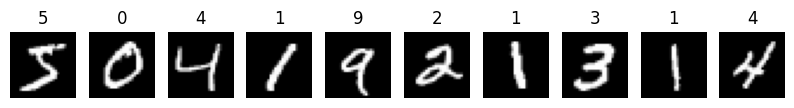

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    img, label = train_data[i]
    axes[i].imshow(np.array(img), cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')
plt.show()

# LeNet-5 Architecture

<div align="center">
<img src="./resources/LeNet-5.png">
</div>

The original research paper: 
* uses trainable subsampling layers, which in my opinion adds unnecessary complexity to the architecture and can be replaced with simple `max pooling` layers.
* uses Euclidean Radial Basis Function units (RBF) to compute the output, which in my opinion adds unnecessary complexity to the architecture and can be replaced with a simple `Linear` layer followed by a `softmax` layer.

In [4]:
import torch.nn as nn

class LeNet(nn.Module):
    """
    LeNet model for image classification.

    This implementation follows the architecture described in the original LeNet-5 paper by Yann LeCun.

    Args:
        None

    Attributes:
        conv (nn.Sequential): Sequential module for convolutional layers.
        fc (nn.Sequential): Sequential module for fully connected layers.

    Methods:
        forward(x): Forward pass through the network.

    """

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5),     # C1
            nn.MaxPool2d(2, 2),     # S2
            nn.Conv2d(6, 16, 5),    # C3
            nn.MaxPool2d(2, 2),     # S4
            nn.Conv2d(16, 120, 5),  # C5
        )
        self.fc = nn.Sequential(
            nn.Linear(120, 84),     # F6
            nn.Linear(84, 10),      # logits
        )

    def forward(self, x):
        """
        Forward pass through the LeNet model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).

        """
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [5]:
from torchsummary import summary

# Create a model instance
lenet = LeNet()

# Visualize a summary of the model
summary(lenet, input_size = (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


# Training

Transform the input data into a `torch.Tensor` and normalize it.

In [6]:
from torchvision.transforms import ToTensor, Compose, Resize

# Define your data transformations and DataLoader here
transform = Compose([
    Resize((32, 32)),
    ToTensor()
])

# Apply the transformations to your data
train_data = MNIST('data/', train=True, download=True, transform=transform)
test_data = MNIST('data/', train=False, download=True, transform=transform)

To train the model, we first need to normalize the images and convert them to tensors.

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define a training function
def train(model, train_loader, num_epochs, learning_rate):
    """
    Train a neural network model using the specified training data.

    Parameters:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader containing the training data.
    - num_epochs (int): The number of training epochs.
    - learning_rate (float): The learning rate for the optimizer.

    Returns:
    None
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if batch_idx % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0
    
    print('Training finished.')

In [8]:
# Define the train data loader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Create a model instance
model = LeNet()
num_epochs = 10
learning_rate = 0.1

train(model, train_loader, num_epochs, learning_rate)

Epoch [1/10], Batch [100/938], Loss: 1.1597
Epoch [1/10], Batch [200/938], Loss: 0.3763
Epoch [1/10], Batch [300/938], Loss: 0.2808
Epoch [1/10], Batch [400/938], Loss: 0.2260
Epoch [1/10], Batch [500/938], Loss: 0.1771
Epoch [1/10], Batch [600/938], Loss: 0.1548
Epoch [1/10], Batch [700/938], Loss: 0.1572
Epoch [1/10], Batch [800/938], Loss: 0.1258
Epoch [1/10], Batch [900/938], Loss: 0.1228
Epoch [2/10], Batch [100/938], Loss: 0.1005
Epoch [2/10], Batch [200/938], Loss: 0.1159
Epoch [2/10], Batch [300/938], Loss: 0.0961
Epoch [2/10], Batch [400/938], Loss: 0.1041
Epoch [2/10], Batch [500/938], Loss: 0.1027
Epoch [2/10], Batch [600/938], Loss: 0.1115
Epoch [2/10], Batch [700/938], Loss: 0.1007
Epoch [2/10], Batch [800/938], Loss: 0.0934
Epoch [2/10], Batch [900/938], Loss: 0.0991
Epoch [3/10], Batch [100/938], Loss: 0.0868
Epoch [3/10], Batch [200/938], Loss: 0.0807
Epoch [3/10], Batch [300/938], Loss: 0.0844
Epoch [3/10], Batch [400/938], Loss: 0.0788
Epoch [3/10], Batch [500/938], L

# Testing

In [9]:
import torch

# Define a test function
def test(model, test_loader):
    """
    Evaluate a trained neural network model on the specified test data and calculate accuracy.

    Parameters:
    - model (torch.nn.Module): The trained neural network model to be evaluated.
    - test_loader (torch.utils.data.DataLoader): DataLoader containing the test data.

    Returns:
    None
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during inference
        for inputs, targets in test_loader:
            # Forward pass
            outputs = model(inputs)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update counts for correct and total predictions
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [10]:
# Define the test data loader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

test(model, test_loader)

Test Accuracy: 98.42%


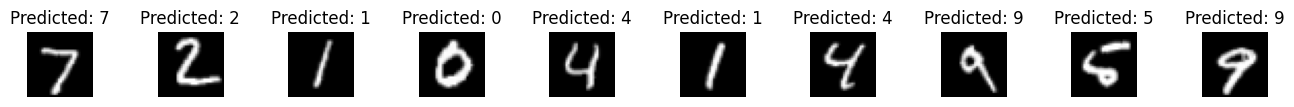

In [11]:
# visualize the model's predictions
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test data
inputs, targets = next(iter(test_loader))

# Forward pass
outputs = model(inputs)

# Get predicted labels
_, predicted = torch.max(outputs, 1)

# Prepare plot
fig, axes = plt.subplots(1, 10, figsize=(16, 3))

# Adjust spacing between subplots
fig.subplots_adjust(wspace=1)

# Plot sample outputs
for i in range(10):
    axes[i].imshow(np.array(inputs[i, 0]), cmap='gray')
    axes[i].set_title(f'Predicted: {predicted[i]}')
    axes[i].axis('off')
plt.show()